# Assignment 3 Graph Visualization

_Submitted by Alexander Ng and Philip Tanofsky_

**Due February 20, 2022**   

Data 620 Web Analytics

# Overview

We select a person-crime bipartite graph database available online as our example for this assignment.   The graph data is published online at  http://konect.cc/networks/moreno_crime/   We find that it is also popular for illustrative use.   A useful resource was Eric Ma's Network Analysis Made Simple online textbook in which he uses the same crime dataset, however, our analysis below is independent.   His textbook is available on https://ericmjl.github.io/Network-Analysis-Made-Simple/04-advanced/01-bipartite/

In section I we import the graph database from raw files and briefly comment on summary statistics.  

In section II, we visualize and discuss the bipartite graph using `networkx` and `matplotlib`.

In section III, we compute selected bipartite graph statistics and general graph theoretic metrics relating them to crime networks.


# Section 1 Data Import of Graph

The graph data is distributed in four text files as described in the accompanying metadata.
Let us assume there are $N$ persons and $M$ edges representing a person-crime pair in which the pair has a  *role* attribute of `Victim`, `Witness` or `Suspect`.

*  `out.moreno_crime_crime`   contains the mapping of length $M$ by persons to crime events. Each pair consists of a `personid` and a `crimeid` but does not state the role of a person.
*  `rel.moreno_crime_crime.person.role` contains the list of $M$ roles of the person-crime pair.  The role in row $j$ matches the person-crime pair in row $j$ of `out.moreno_crime_crime`.
*  `ent.moreno_crime_crime.person.name` contains the list of $N$ names of the persons.  The name in row position $i$ matches personid $i$ which ranges from 1 to $N$.
*  `ent.moreno_crime_crime.person.sex` contains the list of $N$ genders of the persons.  1 is male and 0 is female.

The data forms a bipartite graph of the relationships between $N$ persons and $M$ crimes. 
The metadata specifies that the person is identified by a unique integer on the left column and the crime identifier in the right column.
The edge defines that the person was involved in the crime as either a victim or suspect.

In [251]:
from networkx.algorithms import bipartite
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

We parse the text files below as described in the file description above.  Note that Python uses 0-based indexing by default, so in order to join the Pandas dataframes and lists we find it convenient to align them with the 1-based `personid` and `crimeid` used in the dataset.  Moreover, the files have no headers except for `out.moreno_crime_crime` so we specify `header` = `None`.  Finally, we display the person-crime dataframe below with associated roles.

In [252]:
crime_map_file = "data/out.moreno_crime_crime"  # Contains the crime relationship
df_crime = pd.read_csv( crime_map_file, sep = " ", skiprows = 2, header = None )
A = df_crime.iloc[:,0:2]   # Retain only the first 2 columns.
A.columns = ["Person", "Crime"]   # Rename the column headers
A.index += 1   # Increment the Index to be 1-based

In [253]:
roles_file = "data/rel.moreno_crime_crime.person.role"
roles = pd.read_csv(roles_file, header = None)
roles.columns = ["roles"]
roles.index += 1

In [254]:
genders_file = "data/ent.moreno_crime_crime.person.sex"
genders = pd.read_csv(genders_file , header = None)
genders.columns = ["gender"]

In [255]:
names_file = "data/ent.moreno_crime_crime.person.name"
names = pd.read_csv(names_file, header = None, sep = '\t')
names.columns = ["name"]

In [256]:
person_ids = list(range(1, len(names)+1))

In [257]:
dict = {'personid' : person_ids, 'name' : names["name"], 'gender' : genders["gender"] }
df_person = pd.DataFrame( dict  )

In [258]:
A.join(roles)

,Person,Crime,roles
1,1,1,Suspect
2,1,2,Victim
3,1,3,Victim
4,1,4,Suspect
5,2,5,Victim
...,...,...,...
1472,825,399,Suspect
1473,826,300,Suspect
1474,827,265,Suspect
1475,828,298,Victim


Next, we build the graph object in `networkx` by iterating over the list of edges.   We create nodes on the fly using the keys provided in each edge with person and crime assigned respectively using the `bipartite` graph attribute.

For each node, we assign the attributes `gender`, `name` as expected during node creation.  Less obviously, we add an attribute `latest_role` which is overridden for each person if multiple edges are detected involving that person.   As the file order is unspecified in how a person's role is sorted, the final value of `latest_role` is indeteriminate.
We use the `latest_role` field to group the person nodes to help make a more attribute layout when we position the graph.  While `networkx` has a bipartite_layout feature in version 2.x, since we are frozen at 1.11, that feature is unavailable.   So we will position the graph manually.

In [259]:
G = nx.Graph()
for r, d in A.join(roles).iterrows():
    pid = "p{0}".format(d["Person"])
    cid = "c{0}".format(d["Crime"])
    G.add_node(pid, bipartite = "Person" , name = df_person.loc[d["Person"]-1]["name"] ,
              gender = df_person.loc[d["Person"]-1]["gender"] ,
              latest_role = d["roles"]
              )
    G.add_node(cid, bipartite = "Crime" )
    G.add_edge(pid, cid, role = d["roles"] )
    

We observe that the crime network graph (called $G$ for brevity) has interesting properties as shown in the computations below.

*  has 1476 edges (crime-person roles) and 1380 nodes.  
*  is disconnected and has 20 components
*  the component sizes sorted from largest to smallest number of edges have size 1263 edges and 30 edges down to 2 edges.
*  the number of persons is 829 in $G$
*  the number of crime events is 551 in $G$.

In [260]:
len(G.edges()), len(G.nodes())

(1476, 1380)

In [261]:
nx.is_connected(G)

False

In [262]:
components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
len(components)

20

In [263]:
[len(c) for c in components]

[1263, 30, 18, 13, 9, 7, 6, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2]

In [264]:
person_nodes , crime_nodes = bipartite.sets(G)

In [265]:
len(person_nodes)

829

In [266]:
len(crime_nodes)

551

More advanced graph metrics will be computed in Section 3 below.  So we will defer some of that discussion.   Instead, we consider how to visualize this network using `matplotlib` below. 

# Section 2  Graph Visualization

Because the graph $G$ has 20 connected components of rapidly shrinking size, we choose to plot the smaller components.   It is less practical to visualize a graph with 1263 edges and make sense of the resulting data by visual analysis.   So we will focus on component 2 which has 30 edges.   To visualize it, we will manually specific the layout with person nodes on the right side and the crime nodes on the left side.   Both partitions will arrange the nodes in a column order.   

In addition, we enhance the graph with more attribute information:

*   each person node is labeled with the `name`
*   each person node gender is encoded by color.  $\color{blue}{\text{Blue}}$ for `male` and $\color{cyan}{\text{Cyan}}$ for `female`.
*   each crime node is labeled with its `crimeid` and colored $\color{red}{\text{red}}$.
*   each edge is assigned a color and width as follows:
     -  $\color{red}{\text{Suspect}}$ has width 3
     -  $\color{green}{\text{Victim}}$ has width 2
     -  $\color{goldenrod}{\text{Witness}}$ has width 1


In [267]:
graphs = list(nx.connected_component_subgraphs(G))

In [268]:
subgraphA, subgraphB  = bipartite.sets(graphs[1])

In [269]:
if len(subgraphA) > len(subgraphB):
    person_nodes_subgraph2 = subgraphA
    crime_nodes_subgraph2 = subgraphB
else:
    person_nodes_subgraph2 = subgraphB
    crime_nodes_subgraph2 = subgraphA

In [270]:
#person_nodes_subgraph2

color=nx.get_node_attributes(graphs[1],'name')
color

{'p462': 'LawrenceRobbie',
 'p358': 'HendersonGary',
 'p146': 'CarverJustin',
 'p198': 'CurtisMyles',
 'p317': 'GrantJohn',
 'p260': 'FilmoreDean',
 'p31': 'AsherJames',
 'p541': 'MorrisEvan',
 'p463': 'LeahyCelia',
 'p537': 'MooreTerry',
 'p546': 'MuldoonAlex',
 'p494': 'MandanGrant',
 'p464': 'LeahyDonal',
 'p187': 'CoxJaimie',
 'p364': 'HenryJoseph',
 'p598': 'Pinza Emilio',
 'p616': 'PowersErnest',
 'p804': 'WhittakerRon',
 'p94': 'BradleyBill',
 'p182': 'CottonBert',
 'p157': 'ChanningCarter',
 'p145': 'CarverJason'}

In this bipartite graph component $G_1$, the number of persons is much more than crimes.   To make the graph appear more symmetric, we spread the heights of the crime nodes to be roughly equal in total height as the person nodes.   

In [271]:
nperson_subgraph2 = len(person_nodes_subgraph2)
ncrime_subgraph2 = len(crime_nodes_subgraph2)
k = 1
scale_factor2 = k * nperson_subgraph2 / ncrime_subgraph2

To minimize edge crossings in the bipartite graph and to make labels not overlap the nodes, we use two formatting tricks:

*   persons are sorted by their roles.  For most victims and witnesses, there is only one edge from them.  These nodes with degree 1 have unambiguous association with a `role` based on the unique edge.   Grouping person nodes by roles reduces edge crossings.   However, the general algorithmic problem of minimizing edge crossings even in bipartite graphs is $NP$-complete.

*   labels need to be shifted left and right so they require a different position dictionary `pos_label`

In [272]:
l_sorted_persons_by_role_subgraph2 = sorted(list(person_nodes_subgraph2), 
                                            key = lambda n:graphs[1].node[n]['latest_role'] )


In [273]:
pos = {}

# Update position for node from each group
pos.update((node, (3, k * index)) for index, node in enumerate(l_sorted_persons_by_role_subgraph2))
pos.update((node, (10, index * scale_factor2)) for index, node in enumerate(crime_nodes_subgraph2))

label_shift = 0.3
pos_label = {}
pos_label.update((node, ( 3 - label_shift, k * index)) for index, node in enumerate(l_sorted_persons_by_role_subgraph2))
pos_label.update((node, (10 + label_shift, index * scale_factor2)) for index, node in enumerate(crime_nodes_subgraph2))



In [274]:
# Assign node colors based on graph attributes.

my_labels = [ v[1]['name'] if v[1]['bipartite']=='Person' else v[0] for v in graphs[1].nodes(data=True)]

my_nodes = graphs[1].nodes()


my_node_color = [ ]

for v in graphs[1].nodes(data=True):
    if v[1]['bipartite']=='Person':
        if v[1]['gender']==1:
            my_node_color.append('blue')
        else:
            my_node_color.append('cyan')
    else:
        my_node_color.append('red')
        

In [275]:
label_map = { my_nodes[i] : my_labels[i] for i in range(len(my_nodes)) }

In [276]:
# Assign edge colors and weights based on role attribute.

my_edge_color = [ ]
my_edge_width = [ ]

for ed in graphs[1].edges(data=True):
    if ed[2]['role'] == 'Suspect':
        my_edge_color.append('red')
        my_edge_width.append(3)
    elif ed[2]['role'] == 'Victim':
        my_edge_color.append('green')
        my_edge_width.append(2)
    else:
        my_edge_color.append('yellow')
        my_edge_width.append(1)




We render the bipartite graph below.   A number of tricks were needed to obtain a reasonable format.

*   `plt.figure(figsize=(X,Y))` was required to override the default canvas size which is too small.
*   `plt.suptitle` and `plt.title` are used to produce main and subtitles on the plot.
*   graph draw could not be done with a single call to `networkx.draw()` as the optional parameters for labels and edges were too complex.
*   using `alpha` < 1 increased ink transparency and improved readability of dense edges.

We save the output to an image file in additional rendering the graph inline.

/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/anaconda3/envs/sps620env/lib/pytho

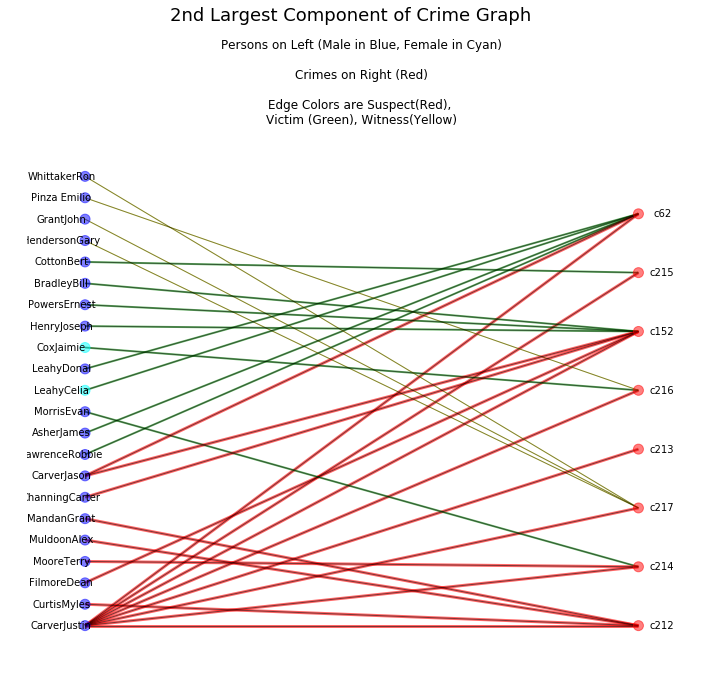

In [277]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("2nd Largest Component of Crime Graph", y = 1.05 ,fontsize= 18)

plt.title("""Persons on Left (Male in Blue, Female in Cyan)\n
Crimes on Right (Red)\n
Edge Colors are Suspect(Red), 
Victim (Green), Witness(Yellow)""", fontsize=12)

nx.draw_networkx_labels(graphs[1], 
                        pos = pos_label , 
                        labels = label_map , font_size = 10)

nx.draw_networkx_edges(graphs[1], pos = pos, 
                       width = my_edge_width, 
                       edge_color = my_edge_color, 
                       alpha = 0.6 )

nx.draw(graphs[1], pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 100, 
        node_color = my_node_color )


plt.savefig("Version2_sorted_people.png")

## Discussion of Graph Visualization

Several comments are in order about the component properties.

*   Most persons involved in crime are men.  Only two individuals in $G_1$ are women (`LeahyCelia` and `CoxJaimie`).
*   One individual `CarverJustin` is a suspect in all the crimes in component $G_1$.
*   `CarverJustin` has a possibly related individual `CarverJason` who is also a suspect in two of the crimes.
*   No other individuals are suspected in more than one crime incident.
*   Crime incidents `c62` and `c152` have multiple victims and multiple suspects.  They appear to be the most serious based on
the degree of the nodes.  However, we have no information about the nature of the crime.  Felonies have higher priority than misdemeanours for policing purposes.

# Section 3 Graph Metrics

The graph metrics are based on the second largest component of the crime graph as identified above.

In [278]:
gr = graphs[1]

The component contains 30 nodes and 30 edges.

In [279]:
(gr.number_of_nodes(), gr.number_of_edges())

(30, 30)

### Diameter
The diameter of the component is 4. The textbook defines, "a graph's diameter is the largest number of vertices that must be traversed in order to travel from one vertex to another." **Note:** The full graph does not have a diameter as the graph is not connected.

In [280]:
nx.diameter(gr)

4

### Average Shortest Path Length
The average shortest path length is just over 3. The average shortest path is defined as "average number of steps along the shortest paths for all possible pairs of network nodes." (https://www.hindawi.com/journals/jam/2013/865643/) **Note:** The full graph does not have an average shortest path length as the graph is not connected.

In [281]:
nx.average_shortest_path_length(gr)

3.0804597701149423

### Density
The density of the component is just under 7% indicating a low density. Graph density is defined as "a measure of how many ties between actors exist compared to how many ties between actors are possible." (https://bookdown.org/omarlizardo/_main/2-9-density.html?fbclid=IwAR2kHox8-cW8kMONVlEyIs3oxAkdWiONwr-DYZWdTmHcLGTrSTCz3djuc9A)

In [282]:
(100 * nx.density(gr))

6.896551724137931

By comparison, the density of the full crime graph is less than two tenths of a percent.

In [283]:
(100 * nx.density(G))

0.15512185894000063

### Degree

The degree of each node in the component is displayed below with node 'p146' with the highest degree value of 8.

In [284]:
{k: v for k, v in sorted(gr.degree().items(), key=lambda item: item[1], reverse=True)}

{'p146': 8,
 'c152': 7,
 'c62': 6,
 'c212': 4,
 'c217': 4,
 'c214': 3,
 'c216': 3,
 'c215': 2,
 'p145': 2,
 'p462': 1,
 'p358': 1,
 'c213': 1,
 'p198': 1,
 'p317': 1,
 'p260': 1,
 'p31': 1,
 'p541': 1,
 'p463': 1,
 'p537': 1,
 'p546': 1,
 'p494': 1,
 'p464': 1,
 'p187': 1,
 'p364': 1,
 'p598': 1,
 'p616': 1,
 'p804': 1,
 'p94': 1,
 'p182': 1,
 'p157': 1}

### Neighbors
With the highest-degree node identified, the neighbor values are displayed for node 'p146'. The output indicates 'p146', or 'CarverJustin', is connected to 8 crime nodes. From the graph above, 'p146' is a suspect in each connected crime.

In [285]:
neighbors = nx.all_neighbors(gr, 'p146')
for n in neighbors:
  print(n)

c212
c213
c62
c214
c216
c215
c217
c152


### Out of the Box Graph
The image below show the out-of-the-box graph of the Networkx and Matplotlib libraries for the second largest component.

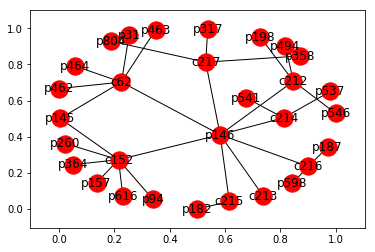

In [286]:
nx.draw_networkx(gr)

## Metrics Discussion
The graph metrics support the bipartite graph visualization in Section 2.
- The diameter of the graph is only 4 as the overall graph only has 30 nodes and 30 edges with a primary node connection in 'p146'.
- The average shortest path length is just over 3. Again, given the small component graph and primary node connection based on 'p146', the average shortes path length is small.
- The density value of almost 7% is expected given the bipartite nature of the graph and the common relationship in 'p146'. The density of the full crime graph being under 1% follows as the entire crime dataset is not connected along with the bipartite nature of the graph data.
